In [1]:
import pandas as pd
import anndata as ad
from loguru import logger 
import time

import numpy as np
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib

from scipy.spatial import Voronoi, voronoi_plot_2d
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, box

import scimap as sm

Running SCIMAP  2.1.3


In [104]:
df = pd.read_csv("../data/processed/20241002_2104_adataobs_RCN.csv")

In [3]:
#subset to one image
image = 991

#subset some cells based on x,y coordinates
x_min = 30000
x_max = 35000
y_min = 30000
y_max = 35000

df_subset = df[(df.imageid == image) & 
            (df.X_centroid > x_min) & 
            (df.X_centroid < x_max) & 
            (df.Y_centroid > y_min) & 
            (df.Y_centroid < y_max)]

In [6]:
df_subset

Unnamed: 0    CellID    Y_centroid    X_centroid    Area  \
5                5       5.0  33618.546875  34516.052557   704.0   
16              16      16.0  33619.819498  34604.065637  1036.0   
27              27      27.0  33608.095588  34691.127941   680.0   
59              59      60.0  33625.428230  34775.601077  1672.0   
233            233     238.0  33622.404348  34565.836957   920.0   
...            ...       ...           ...           ...     ...   
609995      609995  685617.0  33619.926648  34743.376973  1077.0   
610017      610017  685639.0  33604.907258  34442.348790   496.0   
610060      610060  685683.0  33605.438617  34720.659118   839.0   
610072      610072  685695.0  33612.439906  34910.153181  1273.0   
610149      610149  685772.0  33613.623932  34586.205128   585.0   

        MajorAxisLength  MinorAxisLength  Eccentricity  Orientation  \
5             37.037827        24.517285      0.749546    -0.052891   
16            48.218297        30.234288      0.778996    -0.418252   
27            33.816014        26.613989      0.616923    -1.441426   
59            53.354623        43.676333      0.574358    -0.068995   
233           39.742312        30.329401      0.646220    -0.157315   
...                 ...              ...           ...          ...   
609995        56.899281        25.422423      0.894635    -0.017744   
610017        36.621345        18.370367      0.865082    -1.255921   
610060        34.431678        31.358383      0.412975     0.569452   
610072        43.379400        37.568229      0.499977    -0.177195   
610149        48.205234        16.187566      0.941931    -0.158445   

            Extent  ...  DAPI_ratio  DAPI_ratio_pass_nottoolow  \
5       103.639610  ...    0.196251                       True   
16      138.124892  ...    0.363632                       True   
27      100.911688  ...    0.267763                       True   
59      174.267027  ...    0.204256                       True   
233     117.112698  ...    0.206878                       True   
...            ...  ...         ...                        ...   
609995  145.882251  ...    0.225371                       True   
610017   93.497475  ...    0.197793                       True   
610060  109.840620  ...    0.224371                       True   
610072  133.982756  ...    0.234388                       True   
610149  114.012193  ...    0.280996                       True   

        DAPI_ratio_pass_nottoohigh  DAPI_ratio_pass  imageid   phenotype  \
5                             True             True      991  CD4_Tcells   
16                            True             True      991  CD8_Tcells   
27                            True             True      991  CD4_Tcells   
59                            True             True      991  CD4_Tcells   
233                           True             True      991     B_cells   
...                            ...              ...      ...         ...   
609995                        True             True      991  CD4_Tcells   
610017                        True             True      991  CD4_Tcells   
610060                        True             True      991  CD4_Tcells   
610072                        True             True      991  CD4_Tcells   
610149                        True             True      991     B_cells   

        neigh_kmeans_k5  neigh_kmeans_k7  neigh_kmeans_k9  \
5                     4                3                8   
16                    4                3                8   
27                    4                3                8   
59                    4                3                8   
233                   4                3                8   
...                 ...              ...              ...   
609995                4                3                8   
610017                4                3                8   
610060                4                3                8   
610072                

In [7]:
# perhaps index is issue, reset index
df_subset = df_subset.reset_index(drop=True)

In [9]:
df_subset.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
df_subset

CellID    Y_centroid    X_centroid    Area  MajorAxisLength  \
0           5.0  33618.546875  34516.052557   704.0        37.037827   
1          16.0  33619.819498  34604.065637  1036.0        48.218297   
2          27.0  33608.095588  34691.127941   680.0        33.816014   
3          60.0  33625.428230  34775.601077  1672.0        53.354623   
4         238.0  33622.404348  34565.836957   920.0        39.742312   
...         ...           ...           ...     ...              ...   
11471  685617.0  33619.926648  34743.376973  1077.0        56.899281   
11472  685639.0  33604.907258  34442.348790   496.0        36.621345   
11473  685683.0  33605.438617  34720.659118   839.0        34.431678   
11474  685695.0  33612.439906  34910.153181  1273.0        43.379400   
11475  685772.0  33613.623932  34586.205128   585.0        48.205234   

       MinorAxisLength  Eccentricity  Orientation      Extent  Solidity  ...  \
0            24.517285      0.749546    -0.052891  103.639610  0.964384  ...   
1            30.234288      0.778996    -0.418252  138.124892  0.905594  ...   
2            26.613989      0.616923    -1.441426  100.911688  0.965909  ...   
3            43.676333      0.574358    -0.068995  174.267027  0.877690  ...   
4            30.329401      0.646220    -0.157315  117.112698  0.961338  ...   
...                ...           ...          ...         ...       ...  ...   
11471        25.422423      0.894635    -0.017744  145.882251  0.860911  ...   
11472        18.370367      0.865082    -1.255921   93.497475  0.952015  ...   
11473        31.358383      0.412975     0.569452  109.840620  0.961054  ...   
11474        37.568229      0.499977    -0.177195  133.982756  0.970274  ...   
11475        16.187566      0.941931    -0.158445  114.012193  0.891768  ...   

       DAPI_ratio  DAPI_ratio_pass_nottoolow  DAPI_ratio_pass_nottoohigh  \
0        0.196251                       True                        True   
1        0.363632                       True                        True   
2        0.267763                       True                        True   
3        0.204256                       True                        True   
4        0.206878                       True                        True   
...           ...                        ...                         ...   
11471    0.225371                       True                        True   
11472    0.197793                       True                        True   
11473    0.224371                       True                        True   
11474    0.234388                       True                        True   
11475    0.280996                       True                        True   

       DAPI_ratio_pass  imageid   phenotype  neigh_kmeans_k5  neigh_kmeans_k7  \
0                 True      991  CD4_Tcells                4                3   
1                 True      991  CD8_Tcells                4                3   
2                 True      991  CD4_Tcells                4                3   
3                 True      991  CD4_Tcells                4                3   
4                 True      991     B_cells                4                3   
...                ...      ...         ...              ...              ...   
11471             True      991  CD4_Tcells                4                3   
11472             True      991  CD4_Tcells                4                3   
11473             True      991  CD4_Tcells                4                3   
11474             True      991  CD4_Tcells                4                3   
11475             True      991     B_cells                4                3   

       neigh_kmeans_k9  spatial_lda_kmeans_k7  
0                    8                      0  
1                    8                      0  
2                    8                      0  
3                    8                      0  
4                    8                      4  
...      

In [12]:
# lets get just the important columns
df = df_subset[['X_centroid', 'Y_centroid', 'phenotype', 'neigh_kmeans_k7']]

In [13]:
df

X_centroid    Y_centroid   phenotype  neigh_kmeans_k7
0      34516.052557  33618.546875  CD4_Tcells                3
1      34604.065637  33619.819498  CD8_Tcells                3
2      34691.127941  33608.095588  CD4_Tcells                3
3      34775.601077  33625.428230  CD4_Tcells                3
4      34565.836957  33622.404348     B_cells                3
...             ...           ...         ...              ...
11471  34743.376973  33619.926648  CD4_Tcells                3
11472  34442.348790  33604.907258  CD4_Tcells                3
11473  34720.659118  33605.438617  CD4_Tcells                3
11474  34910.153181  33612.439906  CD4_Tcells                3
11475  34586.205128  33613.623932     B_cells                3

[11476 rows x 4 columns]

In [20]:
vor = Voronoi(df[['X_centroid', 'Y_centroid']].values)

In [22]:
dir(vor)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_points',
 '_points',
 '_qhull',
 '_ridge_dict',
 '_update',
 'add_points',
 'close',
 'furthest_site',
 'max_bound',
 'min_bound',
 'ndim',
 'npoints',
 'point_region',
 'points',
 'regions',
 'ridge_dict',
 'ridge_points',
 'ridge_vertices',
 'vertices']

In [63]:
len(vor.vertices)

22924

In [62]:
vor.vertices[:10]

array([[  34838.6262039 ,   27462.57153492],
       [  34812.41602026,   28354.40608915],
       [  34800.7978122 ,   28583.06634625],
       [  34909.34866586,   34968.66207267],
       [  35275.22708522,   35033.2337831 ],
       [1451908.41886844,   31398.66706602],
       [ 849415.17353509,   31297.1583739 ],
       [  58809.66089699,   31753.28648491],
       [-205937.02237745,   33937.66750261],
       [  36135.65926638,   34849.67081545]])

In [59]:
vor.regions[:10]

[[4, -1, 3],
 [11, 4, 3, 10],
 [-1, 12, 28, 29, 27],
 [34, 0, -1, 33],
 [58, 56, 55, 54, 57],
 [57, 28, 29, 30, 54],
 [58, 53, 52, 51, 56],
 [61, 27, 29, 30, 59],
 [60, 32, 55, 54, 30, 59],
 [65, 32, 55, 56, 51, 64]]

In [65]:
vor.points[:10]

array([[34516.05255682, 33618.546875  ],
       [34604.06563707, 33619.81949807],
       [34691.12794118, 33608.09558824],
       [34775.60107656, 33625.42822967],
       [34565.83695652, 33622.40434783],
       [34840.5328874 , 33622.12040134],
       [34655.01675978, 33622.17504655],
       [34441.67744543, 33629.86014551],
       [34493.86560992, 33639.52997932],
       [34629.36383442, 33631.62418301]])

In [68]:
# for point # 1
df.iloc[1]

X_centroid         34604.065637
Y_centroid         33619.819498
phenotype            CD8_Tcells
neigh_kmeans_k7               3
Name: 1, dtype: object

In [69]:
# point 1 in vor.points
vor.points[1]

array([34604.06563707, 33619.81949807])

In [70]:
# what is the index for region for point 1, in the vor.regions array
vor.point_region[1]

2297

In [71]:
# these are the vertices for the region for point 1
vor.regions[vor.point_region[1]]

[7342, 7339, 7338, 7340, 7341]

In [72]:
# get the vertices for the region for point 1
for vertex in vor.regions[vor.point_region[1]]:
    print(vor.vertices[vertex])

[34587.79826225 33637.8730825 ]
[34599.77983492 33603.33274035]
[34622.92566758 33612.41141503]
[34610.28599393 33639.49904679]
[34597.64553538 33642.74755685]


In [73]:
polygon = Polygon([vor.vertices[vertex] for vertex in vor.regions[vor.point_region[1]]])

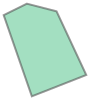

In [74]:
polygon

In [ ]:
# run this for the entire dataframe, export, and check in qupath

In [166]:
def get_voronoi_polygons(df):
    

    df_tmp = df.copy()

    vor = Voronoi(df_tmp[['X_centroid', 'Y_centroid']].values)
    
    polygons = []

    for i in range(len(df_tmp)):
        polygon = Polygon([vor.vertices[vertex] for vertex in vor.regions[vor.point_region[i]]])
        polygons.append(polygon)
    
    df_tmp['geometry'] = polygons

    return df_tmp

In [76]:
df3 = get_voronoi_polygons(df)

In [78]:
df3['classification'] = df3['phenotype']

In [79]:
df3

X_centroid    Y_centroid   phenotype  neigh_kmeans_k7  \
0      34516.052557  33618.546875  CD4_Tcells                3   
1      34604.065637  33619.819498  CD8_Tcells                3   
2      34691.127941  33608.095588  CD4_Tcells                3   
3      34775.601077  33625.428230  CD4_Tcells                3   
4      34565.836957  33622.404348     B_cells                3   
...             ...           ...         ...              ...   
11471  34743.376973  33619.926648  CD4_Tcells                3   
11472  34442.348790  33604.907258  CD4_Tcells                3   
11473  34720.659118  33605.438617  CD4_Tcells                3   
11474  34910.153181  33612.439906  CD4_Tcells                3   
11475  34586.205128  33613.623932     B_cells                3   

                                                geometry classification  
0      POLYGON ((34494.24699426339 33617.005050152584...     CD4_Tcells  
1      POLYGON ((34587.798262245466 33637.87308250389...     CD8_Tcells  
2      POLYGON ((34671.390020655796 33607.75418226846...     CD4_Tcells  
3      POLYGON ((34781.15147551298 33604.746068143235...     CD4_Tcells  
4      POLYGON ((34554.64868782608 33606.42788538691,...        B_cells  
...                                                  ...            ...  
11471  POLYGON ((34724.72414129409 33624.11978821778,...     CD4_Tcells  
11472  POLYGON ((34460.00395257447 33610.89935579909,...     CD4_Tcells  
11473  POLYGON ((34725.418242953616 33584.39868167301...     CD4_Tcells  
11474  POLYGON ((34897.504173693706 33590.6786379236,...     CD4_Tcells  
11475  POLYGON ((34587.798262245466 33637.87308250389...        B_cells  

[11476 rows x 6 columns]

In [86]:
#transform to geodataframe
gdf = gpd.GeoDataFrame(df3, geometry='geometry')
gdf['objectType'] = 'cell'
#filter by box
boundary_box = box(x_min, y_min, x_max, y_max)
filtered_gdf = gdf[gdf.geometry.apply(lambda poly: poly.within(boundary_box))]

In [87]:
filtered_gdf.to_file("../data/processed/20241003_1103_voronoi.geojson", driver='GeoJSON')

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.



In [134]:
filtered_gdf

X_centroid    Y_centroid   phenotype  neigh_kmeans_k7  \
0      34516.052557  33618.546875  CD4_Tcells                3   
1      34604.065637  33619.819498  CD8_Tcells                3   
2      34691.127941  33608.095588  CD4_Tcells                3   
3      34775.601077  33625.428230  CD4_Tcells                3   
4      34565.836957  33622.404348     B_cells                3   
...             ...           ...         ...              ...   
11471  34743.376973  33619.926648  CD4_Tcells                3   
11472  34442.348790  33604.907258  CD4_Tcells                3   
11473  34720.659118  33605.438617  CD4_Tcells                3   
11474  34910.153181  33612.439906  CD4_Tcells                3   
11475  34586.205128  33613.623932     B_cells                3   

                                                geometry classification  \
0      POLYGON ((34494.247 33617.005, 34494.053 33617...     CD4_Tcells   
1      POLYGON ((34587.798 33637.873, 34599.78 33603....     CD8_Tcells   
2      POLYGON ((34671.39 33607.754, 34688.908 33589....     CD4_Tcells   
3      POLYGON ((34781.151 33604.746, 34793.939 33615...     CD4_Tcells   
4      POLYGON ((34554.649 33606.428, 34550.238 33650...        B_cells   
...                                                  ...            ...   
11471  POLYGON ((34724.724 33624.12, 34741.598 33597....     CD4_Tcells   
11472  POLYGON ((34460.004 33610.899, 34459.501 33598...     CD4_Tcells   
11473  POLYGON ((34725.418 33584.399, 34741.4 33596.9...     CD4_Tcells   
11474  POLYGON ((34897.504 33590.679, 34890.245 33614...     CD4_Tcells   
11475  POLYGON ((34587.798 33637.873, 34584.496 33637...        B_cells   

      objectType  
0           cell  
1           cell  
2           cell  
3           cell  
4           cell  
...          ...  
11471       cell  
11472       cell  
11473       cell  
11474       cell  
11475       cell  

[11114 rows x 7 columns]

# That worked beautifully

In [ ]:
# now we want to overlay with merged polygons of the Cellular neighborhoods

# step 1: clone gdf, and merge polygons based on the neigh_kmeans_k7 column 

# step 2: export merge polygons with neigh_kmeans_k7 as classification to geojson

In [108]:
#smaller subset to viz
x_min = 30000
x_max = 31000
y_min = 30000
y_max = 31000

df_subset = df[(df.imageid == image) & 
            (df.X_centroid > x_min) & 
            (df.X_centroid < x_max) & 
            (df.Y_centroid > y_min) & 
            (df.Y_centroid < y_max)]

df_subset = df_subset.reset_index(drop=True)
if 'Unnamed: 0' in df_subset.columns:
    df_subset.drop(columns=['Unnamed: 0'], inplace=True)

# lets get just the important columns
df = df_subset[['X_centroid', 'Y_centroid', 'phenotype', 'neigh_kmeans_k7']]

In [110]:
def get_voronoi_polygons(df):
    df_tmp = df.copy()
    vor = Voronoi(df_tmp[['X_centroid', 'Y_centroid']].values)
    polygons = []
    for i in range(len(df_tmp)):
        polygon = Polygon([vor.vertices[vertex] for vertex in vor.regions[vor.point_region[i]]])
        polygons.append(polygon)
    df_tmp['geometry'] = polygons
    return df_tmp

In [111]:
df = get_voronoi_polygons(df)

In [112]:
df

X_centroid    Y_centroid     phenotype  neigh_kmeans_k7  \
0    30936.835069  30000.290509  Cancer_cells                5   
1    30785.335083  30003.273841       Unknown                5   
2    30298.770115  30004.232759  Cancer_cells                0   
3    30614.452090  30004.592253  Cancer_cells                0   
4    30821.094054  30006.962162  Cancer_cells                5   
..            ...           ...           ...              ...   
600  30589.845855  30989.427461  Cancer_cells                0   
601  30200.365015  30989.863498  Cancer_cells                0   
602  30962.417460  30992.726984  Cancer_cells                0   
603  30830.190880  30999.868505  Cancer_cells                0   
604  30520.120527  30999.841808  Cancer_cells                0   

                                              geometry  
0    POLYGON ((30876.24867399014 29956.510634174545...  
1    POLYGON ((30765.465480010054 30026.00108455213...  
2    POLYGON ((30458.263261246888 28553.60518572448...  
3    POLYGON ((30571.15307002137 29948.44476539374,...  
4    POLYGON ((30803.504219257724 30002.30978360463...  
..                                                 ...  
600  POLYGON ((30575.20780668294 30976.84726533156,...  
601  POLYGON ((29967.320231271464 43586.07854433147...  
602  POLYGON ((30935.61237759614 30984.58732245213,...  
603  POLYGON ((30673.351723471646 51952.15994411897...  
604  POLYGON ((30561.72535990791 31039.77428066338,...  

[605 rows x 5 columns]

In [117]:
gdf = gpd.GeoDataFrame(df, geometry='geometry')
boundary_box = box(x_min, y_min, x_max, y_max)
gdf = gdf[gdf.geometry.apply(lambda poly: poly.within(boundary_box))]

<Axes: >

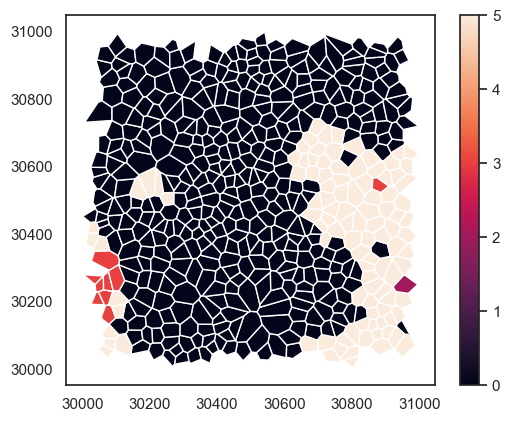

In [119]:
gdf.plot(column='neigh_kmeans_k7', legend=True)

In [ ]:
gdf2 = gdf.dissolve(by='neigh_kmeans_k7')

In [123]:
# looks like it worked
gdf2

geometry  \
neigh_kmeans_k7                                                      
0                MULTIPOLYGON (((30099.558 30150.583, 30120.132...   
2                POLYGON ((30923.604 30239.292, 30930.283 30228...   
3                MULTIPOLYGON (((30059.643 30146.711, 30057.274...   
5                MULTIPOLYGON (((30078.557 30132.339, 30079.822...   

                   X_centroid    Y_centroid     phenotype  
neigh_kmeans_k7                                            
0                30293.729461  30030.753527  Cancer_cells  
2                30963.438732  30247.207369    CD8_Tcells  
3                30080.653907  30161.848485  Cancer_cells  
5                30798.598746  30019.830721  Cancer_cells

<Axes: >

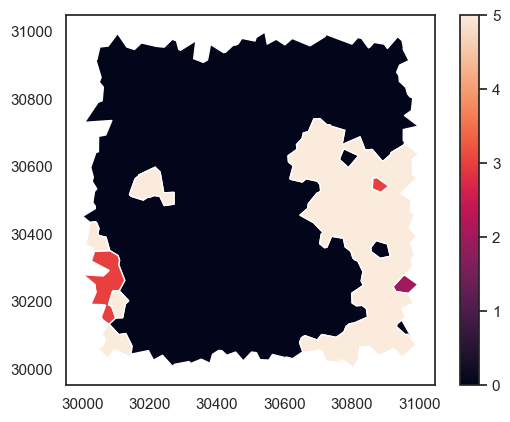

In [124]:
# plot
gdf2['RCN'] = gdf2.index
gdf2.plot(column='RCN', legend=True)

In [125]:
# so far so good, but we can see that each color is one multipolygon, we want to convert to single polygons, so that if they are not adjacent, they are not merged
exploded_gdf = gdf2.explode(index_parts=True)

In [126]:
exploded_gdf

X_centroid    Y_centroid     phenotype  RCN  \
neigh_kmeans_k7                                                    
0               0  30293.729461  30030.753527  Cancer_cells    0   
                1  30293.729461  30030.753527  Cancer_cells    0   
                2  30293.729461  30030.753527  Cancer_cells    0   
                3  30293.729461  30030.753527  Cancer_cells    0   
2               0  30963.438732  30247.207369    CD8_Tcells    2   
3               0  30080.653907  30161.848485  Cancer_cells    3   
                1  30080.653907  30161.848485  Cancer_cells    3   
5               0  30798.598746  30019.830721  Cancer_cells    5   
                1  30798.598746  30019.830721  Cancer_cells    5   
                2  30798.598746  30019.830721  Cancer_cells    5   
                3  30798.598746  30019.830721  Cancer_cells    5   
                4  30798.598746  30019.830721  Cancer_cells    5   

                                                            geometry  
neigh_kmeans_k7                                                       
0               0  POLYGON ((30099.558 30150.583, 30120.132 30151...  
                1  POLYGON ((30989.328 30070.321, 30950.394 30036...  
                2  POLYGON ((30855.445 30359.545, 30871.431 30380...  
                3  POLYGON ((30775.412 30652.472, 30820.233 30631...  
2               0  POLYGON ((30923.604 30239.292, 30930.283 30228...  
3               0  POLYGON ((30059.643 30146.711, 30057.274 30154...  
                1  POLYGON ((30873.818 30567.204, 30909.386 30541...  
5               0  POLYGON ((30078.557 30132.339, 30079.822 30132...  
                1  POLYGON ((30650.113 30091.83, 30660.281 30098....  
                2  POLYGON ((30078.224 30189.753, 30090.52 30229....  
                3  POLYGON ((30016.63 30405.678, 30023.892 30433....  
                4  POLYGON ((30213.61 30513.761, 30198.732 30507....

<Axes: >

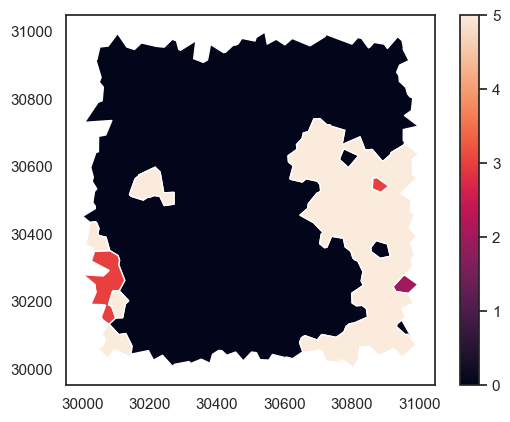

In [127]:
exploded_gdf.plot(column='RCN', legend=True)

In [128]:
exploded_gdf = exploded_gdf.reset_index(drop=True)

In [130]:
exploded_gdf

X_centroid    Y_centroid     phenotype  RCN  \
0   30293.729461  30030.753527  Cancer_cells    0   
1   30293.729461  30030.753527  Cancer_cells    0   
2   30293.729461  30030.753527  Cancer_cells    0   
3   30293.729461  30030.753527  Cancer_cells    0   
4   30963.438732  30247.207369    CD8_Tcells    2   
5   30080.653907  30161.848485  Cancer_cells    3   
6   30080.653907  30161.848485  Cancer_cells    3   
7   30798.598746  30019.830721  Cancer_cells    5   
8   30798.598746  30019.830721  Cancer_cells    5   
9   30798.598746  30019.830721  Cancer_cells    5   
10  30798.598746  30019.830721  Cancer_cells    5   
11  30798.598746  30019.830721  Cancer_cells    5   

                                             geometry  
0   POLYGON ((30099.558 30150.583, 30120.132 30151...  
1   POLYGON ((30989.328 30070.321, 30950.394 30036...  
2   POLYGON ((30855.445 30359.545, 30871.431 30380...  
3   POLYGON ((30775.412 30652.472, 30820.233 30631...  
4   POLYGON ((30923.604 30239.292, 30930.283 30228...  
5   POLYGON ((30059.643 30146.711, 30057.274 30154...  
6   POLYGON ((30873.818 30567.204, 30909.386 30541...  
7   POLYGON ((30078.557 30132.339, 30079.822 30132...  
8   POLYGON ((30650.113 30091.83, 30660.281 30098....  
9   POLYGON ((30078.224 30189.753, 30090.52 30229....  
10  POLYGON ((30016.63 30405.678, 30023.892 30433....  
11  POLYGON ((30213.61 30513.761, 30198.732 30507....

<Axes: >

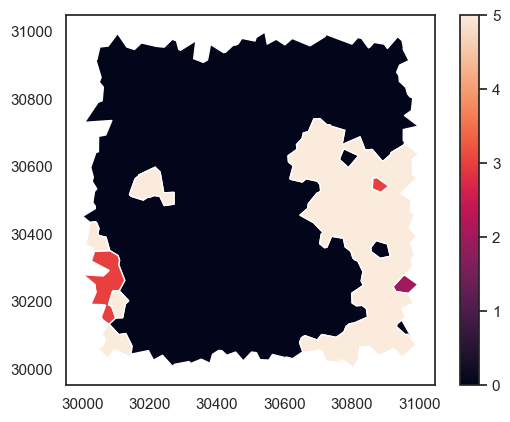

In [129]:
exploded_gdf.plot(column='RCN', legend=True)

In [135]:
# it works! we can now export to geojson
exploded_gdf['classification'] = exploded_gdf['RCN'].astype(str)

In [136]:
exploded_gdf

X_centroid    Y_centroid     phenotype  RCN  \
0   30293.729461  30030.753527  Cancer_cells    0   
1   30293.729461  30030.753527  Cancer_cells    0   
2   30293.729461  30030.753527  Cancer_cells    0   
3   30293.729461  30030.753527  Cancer_cells    0   
4   30963.438732  30247.207369    CD8_Tcells    2   
5   30080.653907  30161.848485  Cancer_cells    3   
6   30080.653907  30161.848485  Cancer_cells    3   
7   30798.598746  30019.830721  Cancer_cells    5   
8   30798.598746  30019.830721  Cancer_cells    5   
9   30798.598746  30019.830721  Cancer_cells    5   
10  30798.598746  30019.830721  Cancer_cells    5   
11  30798.598746  30019.830721  Cancer_cells    5   

                                             geometry classification  
0   POLYGON ((30099.558 30150.583, 30120.132 30151...              0  
1   POLYGON ((30989.328 30070.321, 30950.394 30036...              0  
2   POLYGON ((30855.445 30359.545, 30871.431 30380...              0  
3   POLYGON ((30775.412 30652.472, 30820.233 30631...              0  
4   POLYGON ((30923.604 30239.292, 30930.283 30228...              2  
5   POLYGON ((30059.643 30146.711, 30057.274 30154...              3  
6   POLYGON ((30873.818 30567.204, 30909.386 30541...              3  
7   POLYGON ((30078.557 30132.339, 30079.822 30132...              5  
8   POLYGON ((30650.113 30091.83, 30660.281 30098....              5  
9   POLYGON ((30078.224 30189.753, 30090.52 30229....              5  
10  POLYGON ((30016.63 30405.678, 30023.892 30433....              5  
11  POLYGON ((30213.61 30513.761, 30198.732 30507....              5

In [137]:
exploded_gdf.to_file("../data/processed/20241003_1308_voronoi_CNs.geojson", driver='GeoJSON')

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.



In [141]:
df

X_centroid    Y_centroid     phenotype  neigh_kmeans_k7  \
0    30936.835069  30000.290509  Cancer_cells                5   
1    30785.335083  30003.273841       Unknown                5   
2    30298.770115  30004.232759  Cancer_cells                0   
3    30614.452090  30004.592253  Cancer_cells                0   
4    30821.094054  30006.962162  Cancer_cells                5   
..            ...           ...           ...              ...   
600  30589.845855  30989.427461  Cancer_cells                0   
601  30200.365015  30989.863498  Cancer_cells                0   
602  30962.417460  30992.726984  Cancer_cells                0   
603  30830.190880  30999.868505  Cancer_cells                0   
604  30520.120527  30999.841808  Cancer_cells                0   

                                              geometry  
0    POLYGON ((30876.24867399014 29956.510634174545...  
1    POLYGON ((30765.465480010054 30026.00108455213...  
2    POLYGON ((30458.263261246888 28553.60518572448...  
3    POLYGON ((30571.15307002137 29948.44476539374,...  
4    POLYGON ((30803.504219257724 30002.30978360463...  
..                                                 ...  
600  POLYGON ((30575.20780668294 30976.84726533156,...  
601  POLYGON ((29967.320231271464 43586.07854433147...  
602  POLYGON ((30935.61237759614 30984.58732245213,...  
603  POLYGON ((30673.351723471646 51952.15994411897...  
604  POLYGON ((30561.72535990791 31039.77428066338,...  

[605 rows x 5 columns]

In [142]:
df= pd.read_csv("../data/processed/20241002_2104_adataobs_RCN.csv")

In [143]:
df.columns

Index(['Unnamed: 0', 'CellID', 'Y_centroid', 'X_centroid', 'Area',
       'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation',
       'Extent', 'Solidity', 'filter_by_ann', 'mean_DAPI_bg_abs_above_value',
       'mean_DAPI_bg_abs_below_value', 'Area_filter_nottoobig',
       'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio',
       'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh',
       'DAPI_ratio_pass', 'imageid', 'phenotype', 'neigh_kmeans_k5',
       'neigh_kmeans_k7', 'neigh_kmeans_k9', 'spatial_lda_kmeans_k7'],
      dtype='object')

In [149]:
adataobs_to_voronoi_geojson(
    df= pd.read_csv("../data/processed/20241002_2104_adataobs_RCN.csv"),
    imageid=991,
    subset =[30000, 35000, 30000, 35000],
    category_1='phenotype',
    category_2='neigh_kmeans_k7',
    output_path="../data/geojson_vor/"
)

2024-10-03 13:44:20.371 | INFO     | __main__:adataobs_to_voronoi_geojson:15 - Processing 991, loaded dataframe
2024-10-03 13:44:20.373 | INFO     | __main__:adataobs_to_voronoi_geojson:19 - Subsetting to [30000, 35000, 30000, 35000]
2024-10-03 13:44:20.387 | INFO     | __main__:adataobs_to_voronoi_geojson:32 - Running Voronoi
2024-10-03 13:44:20.584 | INFO     | __main__:adataobs_to_voronoi_geojson:41 - Voronoi done
2024-10-03 13:44:20.585 | INFO     | __main__:adataobs_to_voronoi_geojson:45 - Transformed to geodataframe
2024-10-03 13:44:20.640 | INFO     | __main__:adataobs_to_voronoi_geojson:55 - Filtered out infinite polygons
/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.

2024-10-03 13:44:20.848 | INFO     | __main__:adataobs_to_voronoi_geojson:63 - Exported cells to geojson
2024-10-03 13

Exported 991 to geojson


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.



In [268]:
from scipy.spatial import Voronoi
import time

# Function to calculate major axis length (bounding box diagonal)
def major_axis_length(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    return np.sqrt((maxx - minx) ** 2 + (maxy - miny) ** 2)

# Function to scale the farthest vertex toward the centroid
def scale_pointy_vertex(polygon, scale_factor=0.5):
    centroid = polygon.centroid
    coords = np.array(polygon.exterior.coords)
    # Calculate distances of each vertex to the centroid
    distances = np.linalg.norm(coords - np.array([centroid.x, centroid.y]), axis=1)
    # Find the index of the pointy vertex (farthest from the centroid)
    max_dist_idx = np.argmax(distances)
    # Move the pointy vertex closer to the centroid
    pointy_vertex = coords[max_dist_idx]
    new_vertex = centroid.x + scale_factor * (pointy_vertex[0] - centroid.x), centroid.y + scale_factor * (pointy_vertex[1] - centroid.y)
    # Replace the pointy vertex with the new scaled vertex
    coords[max_dist_idx] = new_vertex
    # Return the modified polygon
    return Polygon(coords)

# Main function to apply filtering and scaling based on thresholds
def process_polygons(gdf, scale_threshold, remove_threshold, scale_factor=0.5):
    def process_polygon(polygon):
        length = major_axis_length(polygon)
        # Remove polygon if the major axis length exceeds remove_threshold
        if length > remove_threshold:
            return None
        # Scale the pointy vertex if the major axis length exceeds scale_threshold
        elif length > scale_threshold:
            return scale_pointy_vertex(polygon, scale_factor)
        # Otherwise, return the original polygon
        return polygon
    # Apply the function to each geometry in the GeoDataFrame
    gdf['geometry'] = gdf['geometry'].apply(process_polygon)
    # Remove None geometries (those that exceeded the remove_threshold)
    return gdf.dropna(subset=['geometry'])

def adataobs_to_voronoi_geojson(
        df,
        imageid:int, 
        subset:list=None, 
        category_1:str="phenotype", 
        category_2:str="CN", 
        output_path:str="../data/processed/"):

    df = df.copy()
    #subset per image
    df = df[(df.imageid == imageid)]
    logger.info(f"Processing {imageid}, loaded dataframe")

    #subset per x,y
    if subset is not None:
        logger.info(f"Subsetting to {subset}")
        assert len(subset) == 4, "subset must be a list of 4 integers"
        x_min, x_max, y_min, y_max = subset
        df = df[(df.X_centroid > x_min) &
                (df.X_centroid < x_max) &
                (df.Y_centroid > y_min) &
                (df.Y_centroid < y_max)]

    #clean subset up
    df = df.reset_index(drop=True)
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)

    logger.info("Running Voronoi")
    # run Voronoi 
    df = df[['X_centroid', 'Y_centroid', category_1, category_2]]    
    vor = Voronoi(df[['X_centroid', 'Y_centroid']].values)
    polygons = []
    for i in range(len(df)):
        polygon = Polygon([vor.vertices[vertex] for vertex in vor.regions[vor.point_region[i]]])
        polygons.append(polygon)
    df['geometry'] = polygons
    logger.info("Voronoi done")

    #transform to geodataframe
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    logger.info("Transformed to geodataframe")

    # filter polygons that go outside of image
    if subset is None:
        x_min = gdf['X_centroid'].min()
        x_max = gdf['X_centroid'].max()
        y_min = gdf['Y_centroid'].min()
        y_max = gdf['Y_centroid'].max()
        logger.info(f"Bounding box: x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max {y_max}")

    boundary_box = box(x_min, y_min, x_max, y_max)
    gdf = gdf[gdf.geometry.apply(lambda poly: poly.within(boundary_box))]
    logger.info("Filtered out infinite polygons")

    # filter polygons that are too large
    gdf['area'] = gdf['geometry'].area
    gdf = gdf[gdf['area'] < gdf['area'].quantile(0.98)]
    logger.info("Filtered out large polygons based on the 98% quantile")
    # filter polygons that are very pointy
    
    # TODO improve filtering by pointiness
    # gdf = process_polygons(gdf, scale_threshold=350, remove_threshold=400, scale_factor=0.3)
    # logger.info("Filtered out pointy polygons")

    # create geodataframe for each cell and their celltype
    gdf2 = gdf.copy()
    gdf2['objectType'] = 'cell'
    gdf2['classification'] = gdf2[category_1]
    
    # merge polygons based on the CN column
    logger.info("Merging polygons for cellular neighborhoods")
    gdf3 = gdf.copy()
    gdf3 = gdf3.dissolve(by=category_2)
    gdf3[category_2] = gdf3.index
    gdf3 = gdf3.explode(index_parts=True)
    gdf3 = gdf3.reset_index(drop=True)
    gdf3['classification'] = gdf3[category_2].astype(str)
    
    #export to geojson
    datetime = time.strftime("%Y%m%d_%H%M")
    gdf2.to_file(f"{output_path}/{datetime}_{imageid}_cells_voronoi.geojson", driver='GeoJSON')
    gdf3.to_file(f"{output_path}/{datetime}_{imageid}_RCN_voronoi.geojson", driver='GeoJSON')

    logger.success(f"Exported {imageid} to geojson")

In [192]:
adataobs_to_voronoi_geojson(
    df= pd.read_csv("../data/processed/20241002_2104_adataobs_RCN.csv"),
    imageid=991,
    category_1='phenotype',
    category_2='neigh_kmeans_k7',
    output_path="../data/geojson_vor/"
)

2024-10-03 14:57:00.440 | INFO     | __main__:adataobs_to_voronoi_geojson:14 - Processing 991, loaded dataframe
2024-10-03 14:57:00.487 | INFO     | __main__:adataobs_to_voronoi_geojson:31 - Running Voronoi
2024-10-03 14:57:15.597 | INFO     | __main__:adataobs_to_voronoi_geojson:40 - Voronoi done
2024-10-03 14:57:15.635 | INFO     | __main__:adataobs_to_voronoi_geojson:44 - Transformed to geodataframe
2024-10-03 14:57:15.640 | INFO     | __main__:adataobs_to_voronoi_geojson:52 - Bounding box: x_min: 878.0318021201414, x_max: 71605.30902111324, y_min: 6.78003120124805, y_max 42764.688888888886
2024-10-03 14:57:18.708 | INFO     | __main__:adataobs_to_voronoi_geojson:56 - Filtered out infinite polygons
/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.

2024-10-03 14:57:30.629 | INFO     | __main__

Exported 991 to geojson


In [184]:
df = pd.read_csv("../data/processed/20241002_2104_adataobs_RCN.csv")
df = df[df.imageid == 991]
df = get_voronoi_polygons(df)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf['area'] = gdf['geometry'].area

x_min = gdf['X_centroid'].min()
x_max = gdf['X_centroid'].max()
y_min = gdf['Y_centroid'].min()
y_max = gdf['Y_centroid'].max()

boundary_box = box(x_min, y_min, x_max, y_max)

gdf = gdf[gdf.geometry.apply(lambda poly: poly.within(boundary_box))]

In [185]:
gdf.area.median()

1577.549570724673

In [186]:
gdf.area.quantile(0.95)

6782.123531181184

In [187]:
gdf = gdf[gdf.area < gdf.area.quantile(0.98)]

In [188]:
gdf.area.median()

1557.7317352716818

In [189]:
gdf.area.quantile(0.95)

5270.141012702496

In [190]:
gdf['classification'] = gdf['phenotype']
gdf['objectType'] = 'cell'
gdf.to_file("../data/processed/size_check_q98_voronoi.geojson", driver='GeoJSON')

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pyogrio/raw.py:698: UserWarning:

'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.



In [195]:
# remove pointy polygons
df = pd.read_csv("../data/processed/20241002_2104_adataobs_RCN.csv")
df = df[df.imageid == 991]

#subset some cells based on x,y coordinates
x_min = 30000
x_max = 40000
y_min = 30000
y_max = 40000

df = df[(df.X_centroid > x_min) &
                (df.X_centroid < x_max) &
                (df.Y_centroid > y_min) &
                (df.Y_centroid < y_max)]

In [196]:
#clean subset up
df = df.reset_index(drop=True)
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

In [198]:
logger.info("Running Voronoi")
# run Voronoi 
vor = Voronoi(df[['X_centroid', 'Y_centroid']].values)
polygons = []
for i in range(len(df)):
    polygon = Polygon([vor.vertices[vertex] for vertex in vor.regions[vor.point_region[i]]])
    polygons.append(polygon)
df['geometry'] = polygons
logger.info("Voronoi done")

2024-10-03 15:37:03.349 | INFO     | __main__:<module>:1 - Running Voronoi
2024-10-03 15:37:04.453 | INFO     | __main__:<module>:9 - Voronoi done


In [199]:
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [201]:
from shapely import LineString

In [202]:
def major_axis_length(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    # Diagonal of the bounding box as an approximation of the major axis length
    return LineString([(minx, miny), (maxx, maxy)]).length

In [203]:
gdf['major_axis_length'] = gdf['geometry'].apply(major_axis_length)

In [207]:
# lets filter by box
boundary_box = box(x_min, y_min, x_max, y_max)
gdf = gdf[gdf.geometry.apply(lambda poly: poly.within(boundary_box))]
# filter by area
gdf['area'] = gdf['geometry'].area
gdf = gdf[gdf['area'] < gdf['area'].quantile(0.98)]


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [208]:
gdf.major_axis_length.describe()

count    38544.000000
mean        78.884744
std         24.353000
min         35.442763
25%         61.784542
50%         73.523987
75%         89.743941
max        258.041645
Name: major_axis_length, dtype: float64

In [209]:
gdf.major_axis_length.quantile(0.95)

127.47792955642751

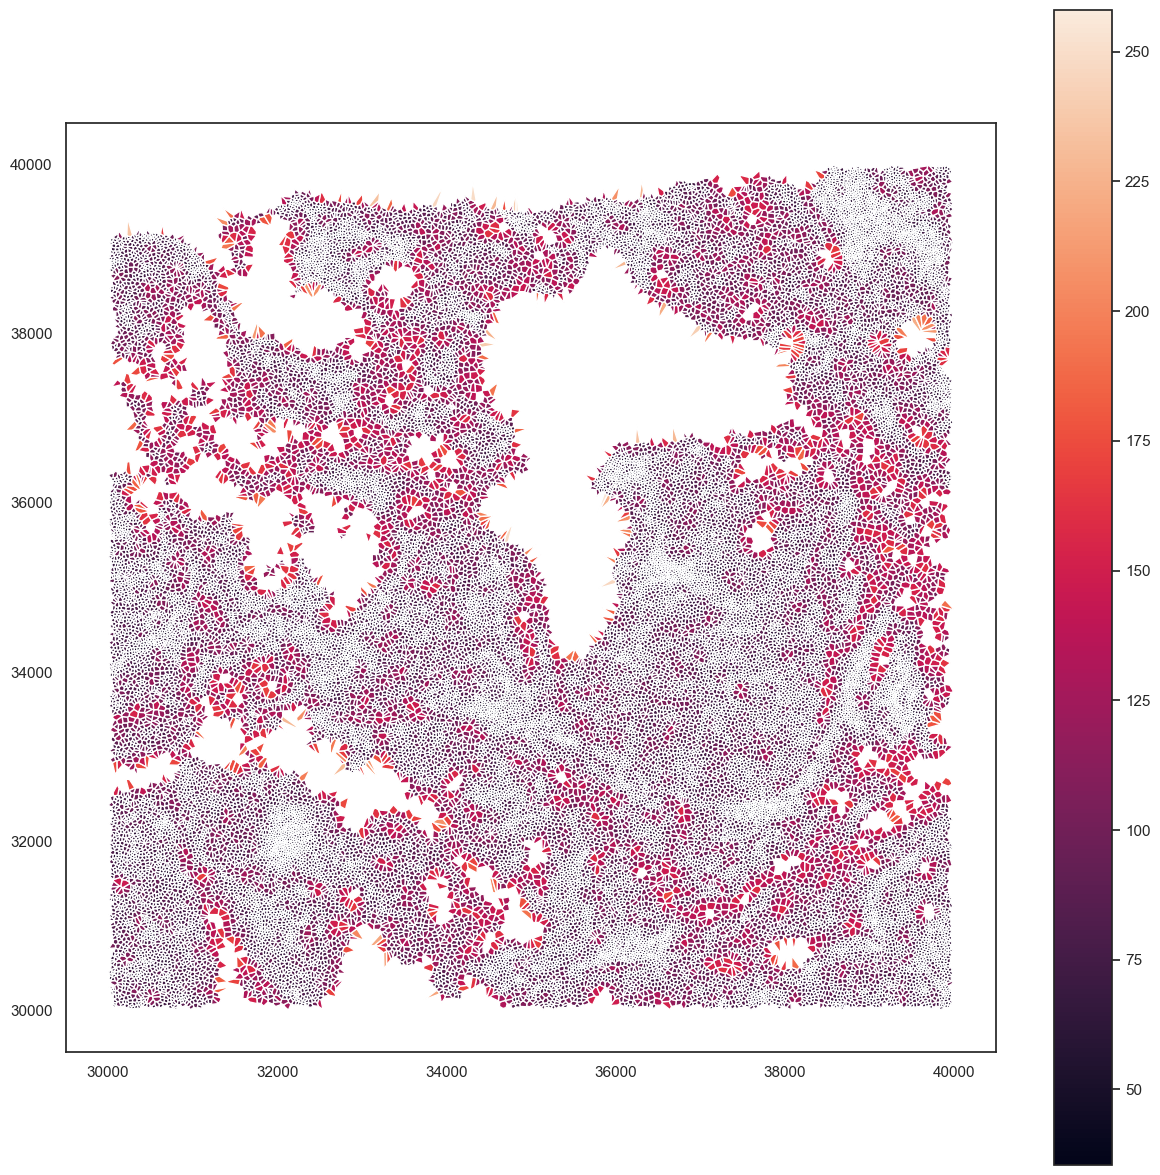

In [249]:
fig, ax = plt.subplots()
gdf.plot(column='major_axis_length', legend=True, ax=ax)
fig.set_figheight(15)
fig.set_figwidth(15)

In [250]:
import geopandas as gpd
from shapely.geometry import Polygon, Point
import numpy as np

# Function to scale the farthest vertex toward the centroid
def scale_pointy_vertex(polygon, threshold, scale_factor=0.5):
    centroid = polygon.centroid
    coords = np.array(polygon.exterior.coords)
    
    # Calculate distances of each vertex to the centroid
    distances = np.linalg.norm(coords - np.array([centroid.x, centroid.y]), axis=1)
    
    # Find the index of the pointy vertex (farthest from the centroid)
    max_dist_idx = np.argmax(distances)
    
    # Check if the major axis length exceeds the threshold
    if distances[max_dist_idx] > threshold:
        # Move the pointy vertex closer to the centroid
        pointy_vertex = coords[max_dist_idx]
        new_vertex = centroid.x + scale_factor * (pointy_vertex[0] - centroid.x), centroid.y + scale_factor * (pointy_vertex[1] - centroid.y)
        
        # Replace the pointy vertex with the new scaled vertex
        coords[max_dist_idx] = new_vertex
    
    # Create a new polygon with the modified coordinates
    return Polygon(coords)

In [259]:
gdf_test = gdf.copy()
gdf_test['geometry'] = gdf_test['geometry'].apply(scale_pointy_vertex, threshold=100, scale_factor=0.2)

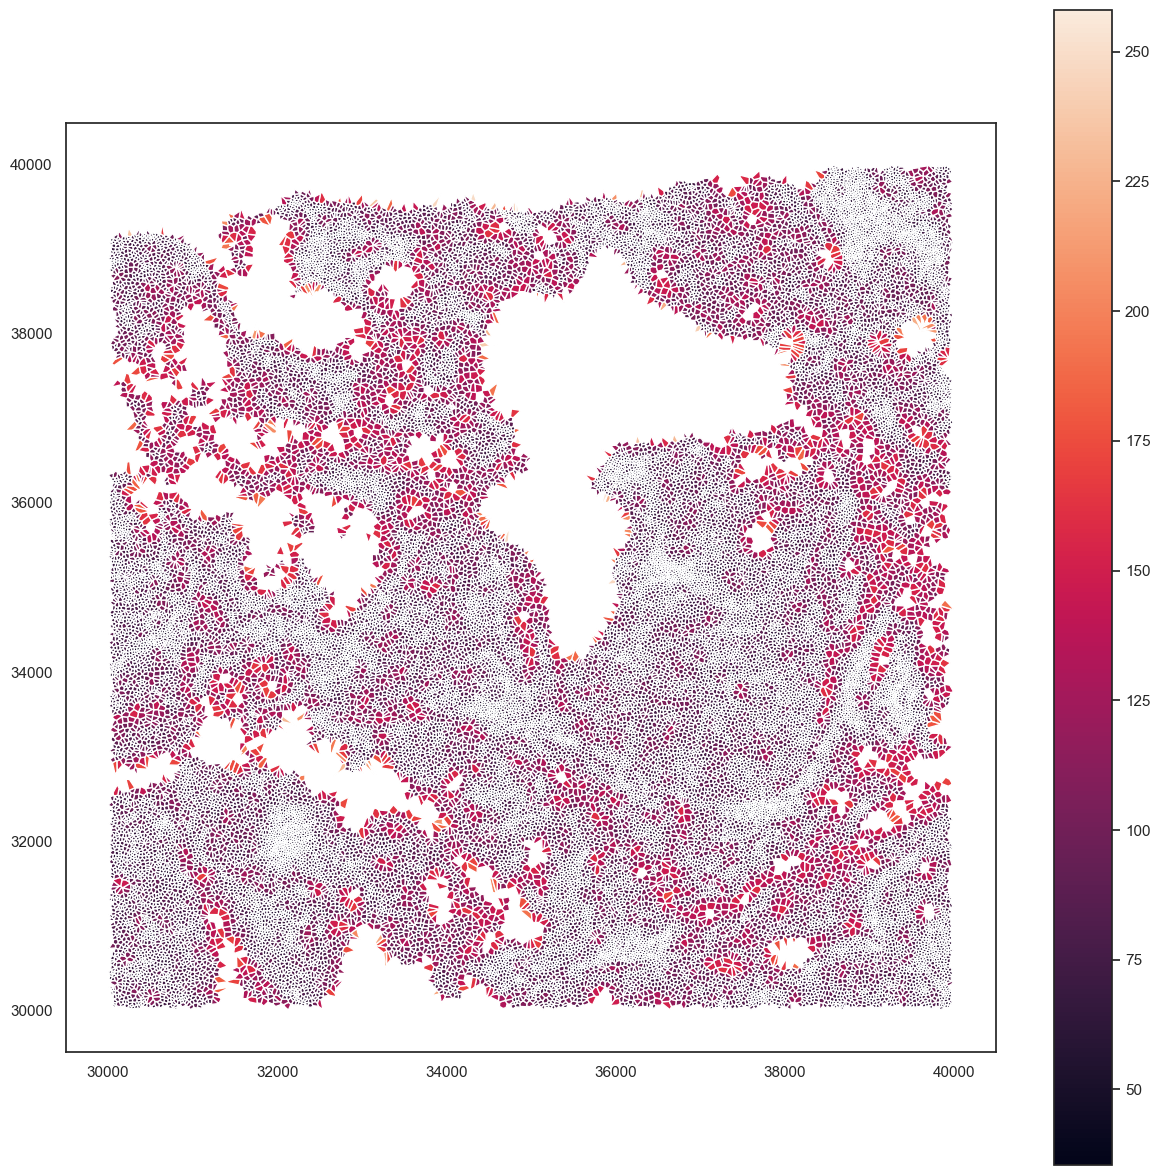

In [260]:
fig, ax = plt.subplots()
gdf_test.plot(column='major_axis_length', legend=True, ax=ax)
fig.set_figheight(15)
fig.set_figwidth(15)

In [261]:
import geopandas as gpd
from shapely.geometry import Polygon, Point
import numpy as np

# Function to calculate major axis length (bounding box diagonal)
def major_axis_length(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    return np.sqrt((maxx - minx) ** 2 + (maxy - miny) ** 2)

# Function to scale the farthest vertex toward the centroid
def scale_pointy_vertex(polygon, scale_factor=0.5):
    centroid = polygon.centroid
    coords = np.array(polygon.exterior.coords)
    # Calculate distances of each vertex to the centroid
    distances = np.linalg.norm(coords - np.array([centroid.x, centroid.y]), axis=1)
    # Find the index of the pointy vertex (farthest from the centroid)
    max_dist_idx = np.argmax(distances)
    # Move the pointy vertex closer to the centroid
    pointy_vertex = coords[max_dist_idx]
    new_vertex = centroid.x + scale_factor * (pointy_vertex[0] - centroid.x), centroid.y + scale_factor * (pointy_vertex[1] - centroid.y)
    # Replace the pointy vertex with the new scaled vertex
    coords[max_dist_idx] = new_vertex
    # Return the modified polygon
    return Polygon(coords)

# Main function to apply filtering and scaling based on thresholds
def process_polygons(gdf, scale_threshold, remove_threshold, scale_factor=0.5):
    def process_polygon(polygon):
        length = major_axis_length(polygon)
        # Remove polygon if the major axis length exceeds remove_threshold
        if length > remove_threshold:
            return None
        # Scale the pointy vertex if the major axis length exceeds scale_threshold
        elif length > scale_threshold:
            return scale_pointy_vertex(polygon, scale_factor)
        # Otherwise, return the original polygon
        return polygon
    # Apply the function to each geometry in the GeoDataFrame
    gdf['geometry'] = gdf['geometry'].apply(process_polygon)
    # Remove None geometries (those that exceeded the remove_threshold)
    return gdf.dropna(subset=['geometry'])

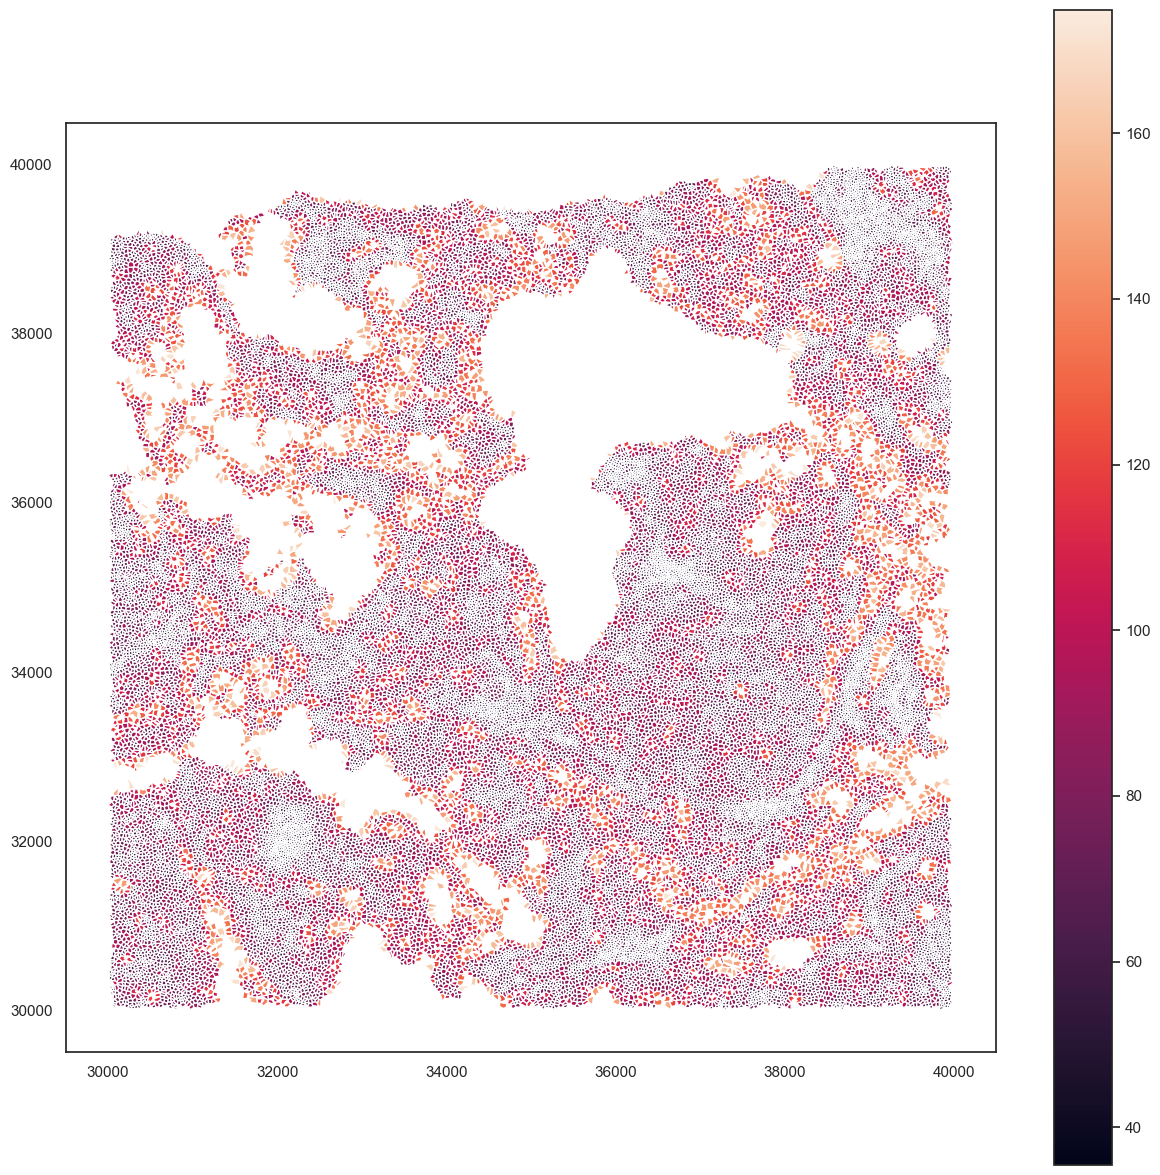

In [263]:
# Apply the processing function to the GeoDataFrame
gdf_test2 = gdf.copy()
gdf_test2 = process_polygons(gdf_test2, scale_threshold=100, remove_threshold=175, scale_factor=0.3)
fig, ax = plt.subplots()
gdf_test2.plot(column='major_axis_length', legend=True, ax=ax)
fig.set_figheight(15)
fig.set_figwidth(15)

In [270]:
adataobs_to_voronoi_geojson(
    df= pd.read_csv("../data/processed/20241002_2104_adataobs_RCN.csv"),
    imageid=991,
    category_1='phenotype',
    category_2='neigh_kmeans_k7',
    output_path="../data/geojson_vor/"
)

2024-10-03 16:20:49.756 | INFO     | __main__:adataobs_to_voronoi_geojson:52 - Processing 991, loaded dataframe
2024-10-03 16:20:49.788 | INFO     | __main__:adataobs_to_voronoi_geojson:69 - Running Voronoi
2024-10-03 16:21:02.287 | INFO     | __main__:adataobs_to_voronoi_geojson:78 - Voronoi done
2024-10-03 16:21:02.316 | INFO     | __main__:adataobs_to_voronoi_geojson:82 - Transformed to geodataframe
2024-10-03 16:21:02.318 | INFO     | __main__:adataobs_to_voronoi_geojson:90 - Bounding box: x_min: 878.0318021201414, x_max: 71605.30902111324, y_min: 6.78003120124805, y_max 42764.688888888886
2024-10-03 16:21:05.158 | INFO     | __main__:adataobs_to_voronoi_geojson:94 - Filtered out infinite polygons
2024-10-03 16:21:05.202 | INFO     | __main__:adataobs_to_voronoi_geojson:99 - Filtered out large polygons based on the 98% quantile
2024-10-03 16:21:07.209 | INFO     | __main__:adataobs_to_voronoi_geojson:102 - Filtered out pointy polygons
2024-10-03 16:21:07.226 | INFO     | __main__:a